# Set Up

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install -q ultralytics

# Configuration

In [20]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
import shutil
import warnings
warnings.filterwarnings('ignore')

print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ PyTorch version: 2.10.0+cu128
✓ CUDA available: True
✓ GPU: Tesla T4


In [21]:
CONFIG = {
    # Data paths
    'dataset_yaml': '/content/drive/MyDrive/dataset/data.yaml',
    'train_images': '/content/drive/MyDrive/dataset/images/train',
    'train_labels_yolo': '/content/drive/MyDrive/dataset/labels/train',
    'train_labels': '/content/drive/MyDrive/dataset/labels_crnn/train',
    'val_images': '/content/drive/MyDrive/dataset/images/val',
    'val_labels_yolo': '/content/drive/MyDrive/dataset/labels/val',
    'val_labels': '/content/drive/MyDrive/dataset/labels_crnn/val',
    'test_images': '/content/drive/MyDrive/dataset/images/test',
    'test_labels': '/content/drive/MyDrive/dataset/labels_crnn/test',

    # Model Paths
    'models_dir': '/content/drive/MyDrive/models',
    'yolo_weights': '/content/drive/MyDrive/models/yolo26m.pt',
    'crnn_weights': '/content/drive/MyDrive/models/crnn_burmese.pth',

    # Training parameters
    'yolo_epochs': 60,
    'yolo_batch': 8,
    'yolo_img_size': 640,

    'crnn_epochs': 60,
    'crnn_batch': 16,
    'crnn_lr': 0.0001,
    'ctc_blank_index': 10,
    'seed': 42,
    'weight_decay': 1e-5,
    'early_stopping_patience': 12,

    # CRNN architecture
    'img_height': 32,
    'img_width': 128,
    'hidden_size': 128,
    'num_classes': 10,  # Burmese digits 0-9

    # Character mapping
    'burmese_digits': ['၀', '၁', '၂', '၃', '၄', '၅', '၆', '၇', '၈', '၉'],
}

print("✓ Configuration loaded")
print(f"  YOLO epochs: {CONFIG['yolo_epochs']}")
print(f"  CRNN epochs: {CONFIG['crnn_epochs']}")
print(f"  Image size: {CONFIG['img_height']}x{CONFIG['img_width']}")

✓ Configuration loaded
  YOLO epochs: 60
  CRNN epochs: 60
  Image size: 32x128


# Preprocessing

In [22]:
class Preprocessor:
    """Preprocessing for NRC images and digit crops"""

    def __init__(self, target_height=32, target_width=128):
        self.target_height = target_height
        self.target_width = target_width

    def preprocess_full_image(self, image):
        """Preprocess full NRC image before YOLO detection"""
        # Denoise
        denoised = cv2.fastNlMeansDenoisingColored(image, h=10, hColor=10)

        # CLAHE contrast enhancement
        lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        enhanced = cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2BGR)

        # Sharpen
        kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
        sharpened = cv2.filter2D(enhanced, -1, kernel)

        return sharpened

    def preprocess_for_crnn(self, image):
      """Preprocess concatenated digit image for CRNN input with background removal"""

      # -------------------------
      # 1. Grayscale
      # -------------------------
      if len(image.shape) == 3:
          gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      else:
          gray = image.copy()

      # -------------------------
      # 2. Background removal (illumination correction)
      # estimate background using large morphological closing
      # -------------------------
      bg_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
      background = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, bg_kernel)

      # subtract background
      corrected = cv2.absdiff(gray, background)

      # increase contrast
      corrected = cv2.normalize(corrected, None, 0, 255, cv2.NORM_MINMAX)

      # -------------------------
      # 3. Denoise
      # -------------------------
      denoised = cv2.fastNlMeansDenoising(corrected, h=10)

      # -------------------------
      # 4. Adaptive threshold
      # -------------------------
      binary = cv2.adaptiveThreshold(
          denoised,
          255,
          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
          cv2.THRESH_BINARY_INV,   # digits white
          15,
          3
      )

      # -------------------------
      # 5. Morphological cleaning
      # -------------------------
      kernel = np.ones((2, 2), np.uint8)
      cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
      cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)

      # -------------------------
      # 6. Resize (preserve aspect ratio)
      # -------------------------
      h, w = cleaned.shape
      scale = min(self.target_width / w, self.target_height / h)

      new_w, new_h = int(w * scale), int(h * scale)
      resized = cv2.resize(cleaned, (new_w, new_h))

      canvas = np.zeros((self.target_height, self.target_width), dtype=np.uint8)
      y_off = (self.target_height - new_h) // 2
      x_off = (self.target_width - new_w) // 2
      canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

      # -------------------------
      # 7. Normalize
      # -------------------------
      normalized = canvas.astype(np.float32) / 255.0

      return normalized

print("✓ Preprocessor loaded")

✓ Preprocessor loaded


# CRNN Model Architecture

In [23]:
class CRNN(nn.Module):
    """CRNN for OCR with CTC loss"""

    def __init__(self, img_height=32, num_classes=10, hidden_size=256):
        super(CRNN, self).__init__()

        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            # Conv block 1: 1 -> 64
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x128 -> 16x64

            # Conv block 2: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x64 -> 8x32

            # Conv block 3: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Conv block 4: 256 -> 256
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 1)),  # 8x32 -> 4x32

            # Conv block 5: 256 -> 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Conv block 6: 512 -> 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 1)),  # 4x32 -> 2x32

            # Final conv: 512 -> 512
            nn.Conv2d(512, 512, kernel_size=2, padding=0),
            nn.ReLU(inplace=True),  # 2x32 -> 1x31
        )

        # Bidirectional LSTM
        self.rnn = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )

        # Output layer: num_classes + 1 for CTC blank
        self.fc = nn.Linear(hidden_size * 2, num_classes + 1)

    def forward(self, x):
        # x: (batch, 1, height, width)

        # CNN: Extract features
        conv = self.cnn(x)  # (batch, 512, 1, W')

        # Reshape for RNN: (batch, W', 512)
        batch, channels, height, width = conv.size()
        assert height == 1, f"Height should be 1, got {height}"
        conv = conv.squeeze(2)  # (batch, 512, W')
        conv = conv.permute(0, 2, 1)  # (batch, W', 512)

        # RNN: Sequence modeling
        rnn_out, _ = self.rnn(conv)  # (batch, W', hidden*2)

        # FC: Classification
        output = self.fc(rnn_out)  # (batch, W', num_classes+1)

        # Transpose for CTC: (W', batch, num_classes+1)
        output = output.permute(1, 0, 2)

        # Log softmax for CTC
        output = nn.functional.log_softmax(output, dim=2)

        return output

print("✓ CRNN model defined")

✓ CRNN model defined


# Dataset Class

In [24]:
class NRCDataset(Dataset):
    """Dataset for CRNN training"""

    def __init__(self, image_paths, labels, preprocessor, char_to_idx):
        self.image_paths = image_paths
        self.labels = labels
        self.preprocessor = preprocessor
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise ValueError(f"Failed to load: {self.image_paths[idx]}")

        # Preprocess
        processed = self.preprocessor.preprocess_for_crnn(image)

        # Add channel dimension: (H, W) -> (1, H, W)
        image_tensor = torch.FloatTensor(processed).unsqueeze(0)

        # Convert label to indices
        label_text = self.labels[idx]
        label_indices = [self.char_to_idx[c] for c in label_text if c in self.char_to_idx]
        label_tensor = torch.LongTensor(label_indices)

        return image_tensor, label_tensor


def collate_fn(batch):
    """Custom collate function for variable length sequences"""
    images, labels = zip(*batch)

    # Stack images
    images = torch.stack(images, 0)

    # Get label lengths
    label_lengths = torch.LongTensor([len(label) for label in labels])

    # Concatenate labels
    labels = torch.cat(labels)

    return images, labels, label_lengths

print("✓ Dataset class loaded")

✓ Dataset class loaded


# Training Functions

In [25]:
def train_yolo(config):
    """Train YOLO detector"""
    print("\n" + "="*60)
    print("TRAINING YOLO DETECTOR")
    print("="*60)

    # Initialize model
    model = YOLO('yolo26m.pt')

    # Train
    results = model.train(
        data=config['dataset_yaml'],
        epochs=config['yolo_epochs'],
        imgsz=config['yolo_img_size'],
        batch=config['yolo_batch'],
        patience=20,
        conf = 0.25,
        save=True,
        project='/content/yolo_runs',
        name='nrc_detector',
        exist_ok=True
    )

    # Save best weights
    best_path = "/content/yolo_runs/nrc_detector/weights/best.pt"
    shutil.copy(best_path, config['yolo_weights'])

    print(f"\n✓ YOLO training complete")
    print(f"✓ Weights saved to: {config['yolo_weights']}")

    return YOLO(config['yolo_weights'])


def train_crnn(train_loader, val_loader, config, device):
    """Train CRNN recognizer"""
    print("\n" + "="*60)
    print("TRAINING CRNN RECOGNIZER")
    print("="*60)

    # Initialize model
    model = CRNN(
        img_height=config['img_height'],
        num_classes=config['num_classes'],
        hidden_size=config['hidden_size']
    ).to(device)

    # Loss and optimizer
    criterion = nn.CTCLoss(blank=config['num_classes'], zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=config['crnn_lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=10, factor=0.5
    )

    best_loss = float('inf')
    patience = 0
    max_patience = 20

    for epoch in range(config['crnn_epochs']):
        # Training
        model.train()
        train_loss = 0

        for images, labels, label_lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['crnn_epochs']}"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(images)  # (T, N, C)
            T, N, C = outputs.size()

            # Input lengths (all frames from CRNN output)
            input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

            # CTC Loss
            loss = criterion(outputs, labels, input_lengths, label_lengths)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, labels, label_lengths in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                T, N, C = outputs.size()
                input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

                loss = criterion(outputs, labels, input_lengths, label_lengths)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), config['crnn_weights'])
            print(f"✓ Best model saved (loss: {best_loss:.4f})")
            patience = 0
        else:
            patience += 1

        # Early stopping
        if patience >= max_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    print(f"\n✓ CRNN training complete")
    print(f"✓ Best weights saved to: {config['crnn_weights']}")

    return model

print("✓ Training functions loaded")

✓ Training functions loaded


# Inference Pipeline

In [26]:
class NRCRecognizer:
    """End-to-end NRC recognition pipeline"""

    def __init__(self, yolo_model, crnn_model, preprocessor, idx_to_char, device):
        self.yolo = yolo_model
        self.crnn = crnn_model.to(device)
        self.crnn.eval()
        self.preprocessor = preprocessor
        self.idx_to_char = idx_to_char
        self.device = device

    def recognize(self, image_path, conf_threshold=0.25):
        """Recognize NRC digits from image"""
        # Load and preprocess full image
        image = cv2.imread(image_path)
        if image is None:
            return "", []

        preprocessed = self.preprocessor.preprocess_full_image(image)

        # YOLO detection
        results = self.yolo(preprocessed, conf=conf_threshold, verbose=False)

        boxes_xyxy = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()

        boxes = np.column_stack((boxes_xyxy, confs, classes))

        if len(boxes) == 0:
            return "", boxes

        # Sort boxes left-to-right
        boxes = boxes[boxes[:, 0].argsort()]

        # Crop and concatenate digits
        digit_crops = []
        for box in boxes:
            x1, y1, x2, y2, conf, cls = box
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            crop = image[y1:y2, x1:x2]
            if crop.size > 0:
                digit_crops.append(crop)

        if not digit_crops:
            return "", boxes

        # Concatenate digits horizontally
        # Resize all crops to same height first
        target_h = 32
        resized_crops = []
        for crop in digit_crops:
            h, w = crop.shape[:2]
            new_w = int(w * target_h / h)
            resized = cv2.resize(crop, (new_w, target_h))
            resized_crops.append(resized)

        # Concatenate
        concat_image = np.hstack(resized_crops)

        # Preprocess for CRNN
        processed = self.preprocessor.preprocess_for_crnn(concat_image)
        image_tensor = torch.FloatTensor(processed).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
        image_tensor = image_tensor.to(self.device)

        # CRNN recognition
        with torch.no_grad():
            output = self.crnn(image_tensor)  # (T, 1, C)

        # Decode CTC output
        pred_text = self._ctc_decode(output)

        return pred_text, boxes

    def _ctc_decode(self, output):
        """Decode CTC output to text"""
        # output: (T, 1, C)
        output = output.squeeze(1)  # (T, C)

        # Get best path
        _, preds = output.max(dim=1)  # (T,)
        preds = preds.cpu().numpy()

        # Remove blanks and duplicates
        decoded = []
        prev = None
        for p in preds:
            if p != len(self.idx_to_char) and p != prev:  # Not blank and not duplicate
                decoded.append(self.idx_to_char[p])
            prev = p

        return ''.join(decoded)

print("✓ Inference pipeline loaded")

✓ Inference pipeline loaded


# Evaluation

In [27]:
def evaluate_model(recognizer, test_data, verbose=True):
    """Evaluate the complete pipeline"""
    print("\n" + "="*60)
    print("EVALUATING MODEL")
    print("="*60)

    correct = 0
    total = len(test_data)
    results = []

    for img_path, gt_label in tqdm(test_data, desc="Evaluating"):
        pred_label, boxes = recognizer.recognize(img_path)

        is_correct = (pred_label == gt_label)
        if is_correct:
            correct += 1

        results.append({
            'image': img_path,
            'ground_truth': gt_label,
            'prediction': pred_label,
            'correct': is_correct,
            'num_detections': len(boxes)
        })

        if verbose and not is_correct:
            print(f"✗ {os.path.basename(img_path)}: GT='{gt_label}' PRED='{pred_label}'")

    accuracy = (correct / total * 100) if total > 0 else 0

    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)
    print(f"Total samples: {total}")
    print(f"Correct: {correct}")
    print(f"Accuracy: {accuracy:.2f}%")
    print("="*60)

    return accuracy, results

print("✓ Evaluation function loaded")

✓ Evaluation function loaded


# Main Training Script

In [28]:

def load_data_from_labels(images_dir, labels_dir):
    """
    Load data where each image has a corresponding .txt label file

    Args:
        images_dir: Directory containing images (jpg/png)
        labels_dir: Directory containing label files (txt)

    Returns:
        List of tuples: [(image_path, label_text), ...]

    Example structure:
        images/img001.jpg
        labels/img001.txt  (contains: ၀၁၉၂၃၇၀၁)
    """
    data = []

    # Get all images
    image_files = glob.glob(os.path.join(images_dir, '*.jpg')) + \
                  glob.glob(os.path.join(images_dir, '*.png')) + \
                  glob.glob(os.path.join(images_dir, '*.jpeg'))

    print(f"\n📂 Loading from {images_dir}")
    print(f"   Found {len(image_files)} images")

    loaded_count = 0
    skipped_count = 0

    for img_path in image_files:
        # Get corresponding label file
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_dir, base_name + '.txt')

        if not os.path.exists(label_path):
            print(f"⚠️  Missing label: {base_name}.txt")
            skipped_count += 1
            continue

        # Read label (just the digit sequence)
        try:
            with open(label_path, 'r', encoding='utf-8') as f:
                label_text = f.read().strip()

            # Validate it's Burmese digits
            if label_text and all(c in CONFIG['burmese_digits'] for c in label_text):
                data.append((img_path, label_text))
                loaded_count += 1
            else:
                print(f"⚠️  Invalid label in {base_name}.txt: '{label_text}'")
                skipped_count += 1
        except Exception as e:
            print(f"⚠️  Error reading {base_name}.txt: {e}")
            skipped_count += 1

    print(f"✅ Loaded: {loaded_count} samples")
    if skipped_count > 0:
        print(f"⚠️  Skipped: {skipped_count} samples")

    return data

print("✓ Data loading function ready")


✓ Data loading function ready


In [29]:
def main_train():
    """
    Complete training pipeline for CRNN

    This function:
    1. Loads your existing YOLO11m model
    2. Loads training and validation data
    3. Trains the CRNN model from scratch
    4. Saves the trained CRNN model
    """

    print("\n" + "="*70)
    print("BURMESE NRC OCR - TRAINING PIPELINE")
    print("="*70)

    # Check device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n🖥️  Device: {device}")
    if device.type == 'cuda':
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Character mappings
    burmese_digits = CONFIG['burmese_digits']
    char_to_idx = {char: idx for idx, char in enumerate(burmese_digits)}
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}

    print(f"\n📝 Character set: {' '.join(burmese_digits)}")
    print(f"   Total classes: {len(burmese_digits)}")

    # Initialize preprocessor
    preprocessor = Preprocessor(
        target_height=CONFIG['img_height'],
        target_width=CONFIG['img_width']
    )
    print(f"\n🔧 Preprocessor initialized")
    print(f"   Target size: {CONFIG['img_height']}x{CONFIG['img_width']}")

    # ========== LOAD YOLO MODEL ==========
    print("\n" + "="*70)
    print("STEP 1: LOADING/CREATING YOLO MODEL")
    print("="*70)

    yolo_path = CONFIG['yolo_weights']

    print("\n" + "="*70)
    print("STEP 1: TRAINING YOLO MODEL")
    print("="*70)

    yolo_model = train_yolo(CONFIG)

    # ========== LOAD DATA ==========
    print(f"\n" + "="*70)
    print("STEP 2: LOADING TRAINING DATA")
    print("="*70)

    try:
        train_data = load_data_from_labels(CONFIG['train_images'], CONFIG['train_labels'])
        val_data = load_data_from_labels(CONFIG['val_images'], CONFIG['val_labels'])
    except Exception as e:
        print(f"\n❌ ERROR loading data: {e}")
        print(f"\n💡 Please check:")
        print(f"   1. Paths in CONFIG are correct")
        print(f"   2. Image and label files exist")
        print(f"   3. Label files contain Burmese digits")
        return None, None

    if len(train_data) == 0:
        print(f"\n❌ ERROR: No training data found!")
        print(f"   Train images path: {CONFIG['train_images']}")
        print(f"   Train labels path: {CONFIG['train_labels']}")
        return None, None

    if len(val_data) == 0:
        print(f"\n⚠️  WARNING: No validation data found!")
        print(f"   Using 20% of training data for validation...")
        # Split training data
        split_idx = int(len(train_data) * 0.8)
        val_data = train_data[split_idx:]
        train_data = train_data[:split_idx]

    print(f"\n📊 Data summary:")
    print(f"   Training samples: {len(train_data)}")
    print(f"   Validation samples: {len(val_data)}")

    # Show some examples
    print(f"\n📋 Sample data (first 3):")
    for i, (img_path, label) in enumerate(train_data[:3]):
        print(f"   {i+1}. {os.path.basename(img_path)} → '{label}'")

    # Separate image paths and labels
    train_images = [item[0] for item in train_data]
    train_labels = [item[1] for item in train_data]
    val_images = [item[0] for item in val_data]
    val_labels = [item[1] for item in val_data]

    # ========== CREATE DATASETS ==========
    print(f"\n" + "="*70)
    print("STEP 3: CREATING PYTORCH DATASETS")
    print("="*70)

    train_dataset = NRCDataset(train_images, train_labels, preprocessor, char_to_idx)
    val_dataset = NRCDataset(val_images, val_labels, preprocessor, char_to_idx)

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['crnn_batch'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['crnn_batch'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True if device.type == 'cuda' else False
    )

    print(f"✅ Datasets created")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    print(f"   Batch size: {CONFIG['crnn_batch']}")

    # ========== TRAIN CRNN ==========
    print(f"\n" + "="*70)
    print("STEP 4: TRAINING CRNN MODEL")
    print("="*70)

    print(f"\n⚙️  Training configuration:")
    print(f"   Epochs: {CONFIG['crnn_epochs']}")
    print(f"   Learning rate: {CONFIG['crnn_lr']}")
    print(f"   Hidden size: {CONFIG['hidden_size']}")
    print(f"   Image size: {CONFIG['img_height']}x{CONFIG['img_width']}")

    print(f"\n🚀 Starting training...")
    print(f"   This may take 30 min - 2 hours depending on dataset size")
    print(f"   Progress will be shown below\n")

    try:
        crnn_model = train_crnn(train_loader, val_loader, CONFIG, device)
    except Exception as e:
        print(f"\n❌ ERROR during training: {e}")
        import traceback
        traceback.print_exc()
        return yolo_model, None

    print(f"\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"\n✅ YOLO model: {CONFIG['yolo_weights']}")
    print(f"✅ CRNN model: {CONFIG['crnn_weights']}")
    print(f"\n💡 Next steps:")
    print(f"   1. Run Cell 11 to test on a single image")
    print(f"   2. Run Cell 9 to evaluate on test set")

    return yolo_model, crnn_model


In [30]:
yolo_model, crnn_model = main_train()


BURMESE NRC OCR - TRAINING PIPELINE

🖥️  Device: cuda
   GPU: Tesla T4
   Memory: 15.6 GB

📝 Character set: ၀ ၁ ၂ ၃ ၄ ၅ ၆ ၇ ၈ ၉
   Total classes: 10

🔧 Preprocessor initialized
   Target size: 32x128

STEP 1: LOADING/CREATING YOLO MODEL

STEP 1: TRAINING YOLO MODEL

TRAINING YOLO DETECTOR
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

Epoch 1/60: 100%|██████████| 7/7 [01:21<00:00, 11.69s/it]


Epoch 1: Train Loss=5.8081, Val Loss=6.6773
✓ Best model saved (loss: 6.6773)


Epoch 2/60: 100%|██████████| 7/7 [01:21<00:00, 11.58s/it]


Epoch 2: Train Loss=3.9122, Val Loss=4.6897
✓ Best model saved (loss: 4.6897)


Epoch 3/60: 100%|██████████| 7/7 [01:19<00:00, 11.30s/it]


Epoch 3: Train Loss=2.8340, Val Loss=2.7226
✓ Best model saved (loss: 2.7226)


Epoch 4/60: 100%|██████████| 7/7 [01:22<00:00, 11.76s/it]


Epoch 4: Train Loss=2.5152, Val Loss=2.5178
✓ Best model saved (loss: 2.5178)


Epoch 5/60: 100%|██████████| 7/7 [01:20<00:00, 11.51s/it]


Epoch 5: Train Loss=2.4781, Val Loss=2.4989
✓ Best model saved (loss: 2.4989)


Epoch 6/60: 100%|██████████| 7/7 [01:19<00:00, 11.41s/it]


Epoch 6: Train Loss=2.4472, Val Loss=2.4770
✓ Best model saved (loss: 2.4770)


Epoch 7/60: 100%|██████████| 7/7 [01:21<00:00, 11.63s/it]


Epoch 7: Train Loss=2.4367, Val Loss=2.4756
✓ Best model saved (loss: 2.4756)


Epoch 8/60: 100%|██████████| 7/7 [01:22<00:00, 11.79s/it]


Epoch 8: Train Loss=2.4285, Val Loss=2.4687
✓ Best model saved (loss: 2.4687)


Epoch 9/60: 100%|██████████| 7/7 [01:21<00:00, 11.63s/it]


Epoch 9: Train Loss=2.4242, Val Loss=2.4640
✓ Best model saved (loss: 2.4640)


Epoch 10/60: 100%|██████████| 7/7 [01:20<00:00, 11.56s/it]


Epoch 10: Train Loss=2.4179, Val Loss=2.4663


Epoch 11/60: 100%|██████████| 7/7 [01:20<00:00, 11.50s/it]


Epoch 11: Train Loss=2.4088, Val Loss=2.4631
✓ Best model saved (loss: 2.4631)


Epoch 12/60: 100%|██████████| 7/7 [01:20<00:00, 11.46s/it]


Epoch 12: Train Loss=2.4028, Val Loss=2.4582
✓ Best model saved (loss: 2.4582)


Epoch 13/60: 100%|██████████| 7/7 [01:21<00:00, 11.68s/it]


Epoch 13: Train Loss=2.3946, Val Loss=2.4576
✓ Best model saved (loss: 2.4576)


Epoch 14/60: 100%|██████████| 7/7 [01:20<00:00, 11.52s/it]


Epoch 14: Train Loss=2.3836, Val Loss=2.4553
✓ Best model saved (loss: 2.4553)


Epoch 15/60: 100%|██████████| 7/7 [01:21<00:00, 11.64s/it]


Epoch 15: Train Loss=2.3755, Val Loss=2.4531
✓ Best model saved (loss: 2.4531)


Epoch 16/60: 100%|██████████| 7/7 [01:20<00:00, 11.53s/it]


Epoch 16: Train Loss=2.3613, Val Loss=2.4458
✓ Best model saved (loss: 2.4458)


Epoch 17/60: 100%|██████████| 7/7 [01:21<00:00, 11.60s/it]


Epoch 17: Train Loss=2.3500, Val Loss=2.4351
✓ Best model saved (loss: 2.4351)


Epoch 18/60: 100%|██████████| 7/7 [01:21<00:00, 11.65s/it]


Epoch 18: Train Loss=2.3400, Val Loss=2.4315
✓ Best model saved (loss: 2.4315)


Epoch 19/60: 100%|██████████| 7/7 [01:22<00:00, 11.78s/it]


Epoch 19: Train Loss=2.3260, Val Loss=2.4245
✓ Best model saved (loss: 2.4245)


Epoch 20/60: 100%|██████████| 7/7 [01:21<00:00, 11.59s/it]


Epoch 20: Train Loss=2.3117, Val Loss=2.4265


Epoch 21/60: 100%|██████████| 7/7 [01:20<00:00, 11.46s/it]


Epoch 21: Train Loss=2.2986, Val Loss=2.4203
✓ Best model saved (loss: 2.4203)


Epoch 22/60: 100%|██████████| 7/7 [01:20<00:00, 11.55s/it]


Epoch 22: Train Loss=2.2858, Val Loss=2.3982
✓ Best model saved (loss: 2.3982)


Epoch 23/60: 100%|██████████| 7/7 [01:18<00:00, 11.22s/it]


Epoch 23: Train Loss=2.2765, Val Loss=2.4092


Epoch 24/60: 100%|██████████| 7/7 [01:18<00:00, 11.17s/it]


Epoch 24: Train Loss=2.2671, Val Loss=2.4474


Epoch 25/60: 100%|██████████| 7/7 [01:20<00:00, 11.53s/it]


Epoch 25: Train Loss=2.2540, Val Loss=2.4006


Epoch 26/60: 100%|██████████| 7/7 [01:20<00:00, 11.44s/it]


Epoch 26: Train Loss=2.2489, Val Loss=2.4123


Epoch 27/60: 100%|██████████| 7/7 [01:20<00:00, 11.53s/it]


Epoch 27: Train Loss=2.2418, Val Loss=2.6101


Epoch 28/60: 100%|██████████| 7/7 [01:18<00:00, 11.16s/it]


Epoch 28: Train Loss=2.2337, Val Loss=2.4331


Epoch 29/60: 100%|██████████| 7/7 [01:20<00:00, 11.47s/it]


Epoch 29: Train Loss=2.2252, Val Loss=2.4502


Epoch 30/60: 100%|██████████| 7/7 [01:19<00:00, 11.39s/it]


Epoch 30: Train Loss=2.2157, Val Loss=2.4381


Epoch 31/60: 100%|██████████| 7/7 [01:21<00:00, 11.64s/it]


Epoch 31: Train Loss=2.2000, Val Loss=2.4253


Epoch 32/60: 100%|██████████| 7/7 [01:21<00:00, 11.61s/it]


Epoch 32: Train Loss=2.1962, Val Loss=2.4942


Epoch 33/60: 100%|██████████| 7/7 [01:20<00:00, 11.43s/it]


Epoch 33: Train Loss=2.1774, Val Loss=2.4462


Epoch 34/60: 100%|██████████| 7/7 [01:20<00:00, 11.46s/it]


Epoch 34: Train Loss=2.1718, Val Loss=2.4165


Epoch 35/60: 100%|██████████| 7/7 [01:20<00:00, 11.52s/it]


Epoch 35: Train Loss=2.1653, Val Loss=2.4613


Epoch 36/60: 100%|██████████| 7/7 [01:19<00:00, 11.41s/it]


Epoch 36: Train Loss=2.1549, Val Loss=2.4965


Epoch 37/60: 100%|██████████| 7/7 [01:20<00:00, 11.52s/it]


Epoch 37: Train Loss=2.1488, Val Loss=2.4029


Epoch 38/60: 100%|██████████| 7/7 [01:18<00:00, 11.19s/it]


Epoch 38: Train Loss=2.1446, Val Loss=2.4747


Epoch 39/60: 100%|██████████| 7/7 [01:21<00:00, 11.61s/it]


Epoch 39: Train Loss=2.1316, Val Loss=2.4490


Epoch 40/60: 100%|██████████| 7/7 [01:21<00:00, 11.65s/it]


Epoch 40: Train Loss=2.1334, Val Loss=2.4302


Epoch 41/60: 100%|██████████| 7/7 [01:18<00:00, 11.25s/it]


Epoch 41: Train Loss=2.1181, Val Loss=2.4664


Epoch 42/60: 100%|██████████| 7/7 [01:20<00:00, 11.46s/it]


Epoch 42: Train Loss=2.1077, Val Loss=2.4577

Early stopping triggered after 42 epochs

✓ CRNN training complete
✓ Best weights saved to: /content/drive/MyDrive/models/crnn_burmese.pth

✅ TRAINING COMPLETE!

✅ YOLO model: /content/drive/MyDrive/models/yolo26m.pt
✅ CRNN model: /content/drive/MyDrive/models/crnn_burmese.pth

💡 Next steps:
   1. Run Cell 11 to test on a single image
   2. Run Cell 9 to evaluate on test set


# Inference Example


Image: IMG_110349.jpeg
Detected digits: 8
Recognized: 


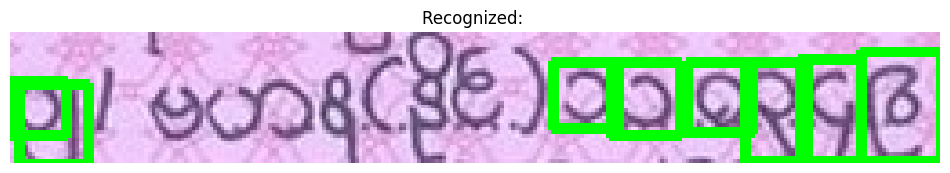

('',
 array([[          0,      13.212,      15.608,      28.969,     0.62667,           1],
        [      2.767,      14.147,      21.506,          36,     0.37278,           2],
        [     149.63,      8.3516,       167.9,      26.743,     0.85496,           1],
        [     165.56,      8.6199,      184.61,      28.399,     0.89022,           1],
        [     186.14,      8.5207,      204.27,       27.22,     0.55403,           0],
        [     202.54,      8.7543,      219.25,      35.584,     0.63186,           3],
        [     217.62,      7.3189,      234.56,      35.159,     0.81896,           4],
        [     234.58,      5.8654,         256,       35.55,     0.81332,           9]], dtype=float32))

In [31]:
def test_inference(image_path):
    """Test inference on a single image"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Character mappings
    burmese_digits = CONFIG['burmese_digits']
    idx_to_char = {idx: char for idx, char in enumerate(burmese_digits)}

    # Load models
    yolo_model = YOLO(CONFIG['yolo_weights'])

    crnn_model = CRNN(
        img_height=CONFIG['img_height'],
        num_classes=CONFIG['num_classes'],
        hidden_size=CONFIG['hidden_size']
    )
    crnn_model.load_state_dict(torch.load(CONFIG['crnn_weights']))
    crnn_model = crnn_model.to(device)

    # Initialize preprocessor and recognizer
    preprocessor = Preprocessor(
        target_height=CONFIG['img_height'],
        target_width=CONFIG['img_width']
    )

    recognizer = NRCRecognizer(yolo_model, crnn_model, preprocessor, idx_to_char, device)

    # Recognize
    result, boxes = recognizer.recognize(image_path)

    print(f"\n{'='*60}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Detected digits: {len(boxes)}")
    print(f"Recognized: {result}")
    print(f"{'='*60}")

    # Visualize
    img = cv2.imread(image_path)
    for box in boxes:
        x1, y1, x2, y2, conf, cls = box
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Recognized: {result}")
    plt.axis('off')
    plt.show()

    return result, boxes

# Example usage:
#test_inference('/content/drive/MyDrive/dataset/images/val/IMG_052905.jpg')
#test_inference('/content/drive/MyDrive/dataset/images/val/img_072309.jpeg')
test_inference('/content/drive/MyDrive/dataset/images/train/IMG_110349.jpeg')


Image: img_072309.jpeg
Detected digits: 7
Recognized: 


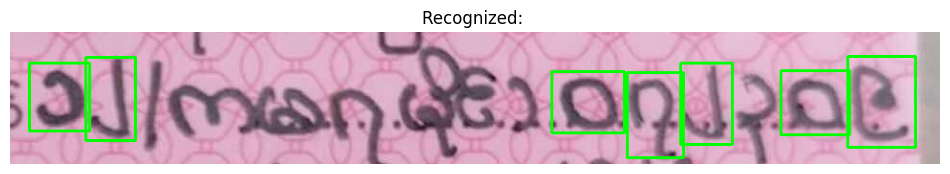

('',
 array([[     20.678,      32.206,      83.442,      103.08,     0.90534,           1],
        [     79.605,      26.482,      131.92,      113.58,     0.81792,           2],
        [     567.36,      41.534,       643.4,      105.09,     0.81547,           0],
        [     646.27,      42.627,      705.19,      131.51,      0.8347,           7],
        [     702.51,      32.731,      756.12,      117.93,     0.80327,           2],
        [      807.1,      40.348,      879.63,      107.73,     0.29148,           8],
        [     877.34,      25.716,      948.02,      120.77,      0.7324,           9]], dtype=float32))

In [32]:
test_inference('/content/drive/MyDrive/dataset/images/val/img_072309.jpeg')


Image: IMG_052905.jpg
Detected digits: 3
Recognized: 


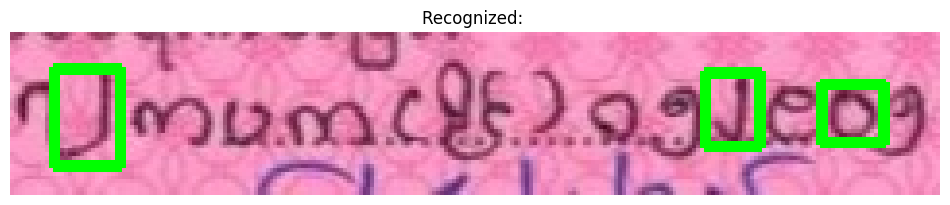

('',
 array([[      11.27,      9.6025,      28.308,      34.007,     0.57787,           2],
        [     179.93,      10.041,         193,      29.931,     0.33748,           2],
        [     209.58,      13.499,      225.33,        28.9,     0.30326,           0]], dtype=float32))

In [33]:
test_inference('/content/drive/MyDrive/dataset/images/val/IMG_052905.jpg')

In [34]:
def test_yolo_on_multiple_images(image_folder, num_images=5):
    """
    Test YOLO on multiple images from a folder
    """
    # Get all images in folder
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_paths = []

    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(image_folder, ext)))

    if not image_paths:
        print(f"❌ No images found in {image_folder}")
        return

    # Limit to num_images
    test_images = image_paths[:num_images]

    print(f"🧪 Testing YOLO on {len(test_images)} images...")
    print(f"   Folder: {image_folder}")

    # Load YOLO model once
    try:
        model = YOLO('yolo26n.pt')
        print(f"✓ Loaded YOLOv8n model")
    except:
        print("❌ Could not load YOLO model")
        return

    results_summary = []

    for img_path in test_images:
        print(f"\n{'='*60}")
        print(f"Testing: {os.path.basename(img_path)}")

        # Test detection
        detections = test_yolo_detection(img_path, model=model)

        if detections is not None:
            boxes, confidences, classes = detections
            results_summary.append({
                'image': os.path.basename(img_path),
                'detections': len(boxes),
                'avg_confidence': np.mean(confidences) if len(confidences) > 0 else 0
            })

    # Print summary
    print(f"\n{'='*60}")
    print("📊 TEST SUMMARY")
    print("="*60)

    if results_summary:
        total_detections = sum(r['detections'] for r in results_summary)
        avg_detections = total_detections / len(results_summary)
        avg_confidence = np.mean([r['avg_confidence'] for r in results_summary])

        print(f"Images tested: {len(results_summary)}")
        print(f"Total detections: {total_detections}")
        print(f"Average detections per image: {avg_detections:.1f}")
        print(f"Average confidence: {avg_confidence:.3f}")

        print(f"\nDetails:")
        for result in results_summary:
            print(f"  {result['image']}: {result['detections']} detections "
                  f"(avg conf: {result['avg_confidence']:.3f})")
    else:
        print("❌ No detections in any image!")